<a href="https://colab.research.google.com/github/doogzultz/time_series_project/blob/main/model_test_simple_and_classical.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from pandas.plotting import scatter_matrix
from tensorflow.keras.layers import Layer, Dense, Dropout, Input, \
Flatten, Concatenate, Conv1D, LSTM, Bidirectional, BatchNormalization, Activation, TimeDistributed, Lambda, MaxPooling1D
from tensorflow.keras.models import Model
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow.keras.backend as K
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.utils import shuffle
from sklearn.compose import ColumnTransformer
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import GridSearchCV, train_test_split, ParameterGrid
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer, mean_absolute_percentage_error
import os
from sklearn.utils import shuffle

In [2]:
class g:
  window_size = 8
  batch_size = 16
  valid_size = .1
  test_size = .1
  valid_cutoff = 84
  test = False

In [3]:
url = "https://raw.githubusercontent.com/doogzultz/time_series_project/main/data.csv"
data = pd.read_csv(url)

In [4]:
data.columns

Index(['date', 'identifier', 'market_cap', 'sector', 'index_membership',
       'factor_1', 'factor_2', 'factor_3', 'factor_4', 'factor_5', 'factor_6',
       'factor_7', 'factor_8', 'factor_9', 'factor_10', 'target'],
      dtype='object')

In [5]:
data.drop(columns = 'index_membership', inplace = True)

In [6]:
data.sort_values(by = ['identifier', 'date'], inplace = True)
data

,date,identifier,market_cap,sector,factor_1,factor_2,factor_3,factor_4,factor_5,factor_6,factor_7,factor_8,factor_9,factor_10,target
82,2010-01-06,AD41WBQFVG43,5.843968e+10,35,0.766639,-0.000032,0.832677,0.500608,0.193489,0.246089,0.753702,0.792736,-0.000005,0.109029,-0.000006
400,2010-01-13,AD41WBQFVG43,4.758865e+10,35,0.907349,-0.022933,0.346457,0.581694,0.648483,0.872304,0.723412,0.333230,-0.009504,0.121348,-0.008721
718,2010-01-20,AD41WBQFVG43,3.374757e+10,35,0.476465,-0.000114,0.592328,0.379747,0.810961,0.017737,0.619208,0.058918,-0.000099,0.890898,-0.000081
1036,2010-01-27,AD41WBQFVG43,4.908395e+10,35,0.265141,-0.000034,0.521405,0.682492,0.547349,0.155915,0.068966,0.699718,-0.000037,0.355059,-0.000018
1354,2010-02-03,AD41WBQFVG43,2.729189e+10,35,0.423987,0.000197,0.950500,0.628533,0.956287,0.426634,0.752799,0.961276,0.000163,0.196711,0.000318
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12552,2010-10-06,ZMYXRS4KVOG2,6.504496e+08,25,0.069622,0.009936,0.588354,0.447469,0.353549,0.767779,0.790632,0.308049,0.012255,0.281193,0.005117
12862,2010-10-13,ZMYXRS4KVOG2,1.403710e+09,25,0.343444,0.002566,0.394802,0.143162,0.116762,0.744089,0.825323,0.559633,0.001058,0.755124,0.000446
13172,2010-10-20,ZMYXRS4KVOG2,7.284687e+08,25,0.857557,0.000146,0.892729,0.113346,0.574870,0.990100,0.319424,0.591153,0.000054,0.933679,0.000035
13483,2010-10-27,ZMYXRS4KVOG2,7.766592e+08,25,0.093894,-0.000885,0.311392,0.768537,0.589851,0.289180,0.431484,0.373209,-0.000411,0.225972,-0.000242


In [7]:
(data== 0).sum(axis=0)

date           0
identifier     0
market_cap     0
sector         0
factor_1       0
factor_2      68
factor_3       0
factor_4       0
factor_5       0
factor_6       0
factor_7       0
factor_8       0
factor_9      68
factor_10      0
target        68
dtype: int64

In [8]:
ident_counts= data.value_counts('identifier')
ident_counts

identifier
AD41WBQFVG43    104
UZ4DWDZ8ALZ4    104
KR47536Y10D4    104
KPJ8FTV9ESJ3    104
KMHQ727PU8E2    104
               ... 
PNUM57CYEB27      5
KHKNKSMXBWP3      5
LYCPQJ19AOY0      5
RENR64FT3I74      5
LALJLSN9UMP2      2
Length: 356, dtype: int64

In [9]:
data.value_counts('sector', normalize = True).sort_index()

sector
10    0.049221
15    0.093162
20    0.208527
25    0.132849
30    0.072759
35    0.049003
40    0.232812
45    0.051674
50    0.038352
55    0.071642
dtype: float64

In [10]:
data[data['identifier'].isin(list(ident_counts[ident_counts.values > 80].index))].value_counts('sector', normalize = True).sort_index()

sector
10    0.052423
15    0.093655
20    0.212044
25    0.126521
30    0.076618
35    0.045433
40    0.228443
45    0.052423
50    0.039048
55    0.073392
dtype: float64

In [11]:
data[data['identifier'].isin(list(ident_counts[ident_counts.values <= 80].index))].value_counts('sector', normalize = True).sort_index()

sector
10    0.010229
15    0.087152
20    0.165712
25    0.209902
30    0.025777
35    0.092471
40    0.286007
45    0.042553
50    0.029869
55    0.050327
dtype: float64

([<matplotlib.axis.XTick at 0x7f08d36af110>,
 [])

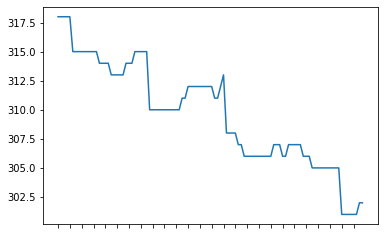

In [23]:
plt.plot(data.value_counts('date').sort_index())
plt.xticks(range(0, 104, 4), labels = [])

In [ ]:
sector_onehot = pd.get_dummies(data['sector'], prefix='sector')
#ident_onehot = pd.get_dummies(data['identifier'], prefix='ident')
#ident_onehot.head()

In [ ]:
target = data['target']
data.drop(columns = ['sector', 'target'], inplace = True)
data = pd.concat([data, sector_onehot, target], axis = 1)
data

,date,identifier,market_cap,factor_1,factor_2,factor_3,factor_4,factor_5,factor_6,factor_7,...,sector_15,sector_20,sector_25,sector_30,sector_35,sector_40,sector_45,sector_50,sector_55,target
82,2010-01-06,AD41WBQFVG43,5.843968e+10,0.766639,-0.000032,0.832677,0.500608,0.193489,0.246089,0.753702,...,0,0,0,0,1,0,0,0,0,-0.000006
400,2010-01-13,AD41WBQFVG43,4.758865e+10,0.907349,-0.022933,0.346457,0.581694,0.648483,0.872304,0.723412,...,0,0,0,0,1,0,0,0,0,-0.008721
718,2010-01-20,AD41WBQFVG43,3.374757e+10,0.476465,-0.000114,0.592328,0.379747,0.810961,0.017737,0.619208,...,0,0,0,0,1,0,0,0,0,-0.000081
1036,2010-01-27,AD41WBQFVG43,4.908395e+10,0.265141,-0.000034,0.521405,0.682492,0.547349,0.155915,0.068966,...,0,0,0,0,1,0,0,0,0,-0.000018
1354,2010-02-03,AD41WBQFVG43,2.729189e+10,0.423987,0.000197,0.950500,0.628533,0.956287,0.426634,0.752799,...,0,0,0,0,1,0,0,0,0,0.000318
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12552,2010-10-06,ZMYXRS4KVOG2,6.504496e+08,0.069622,0.009936,0.588354,0.447469,0.353549,0.767779,0.790632,...,0,0,1,0,0,0,0,0,0,0.005117
12862,2010-10-13,ZMYXRS4KVOG2,1.403710e+09,0.343444,0.002566,0.394802,0.143162,0.116762,0.744089,0.825323,...,0,0,1,0,0,0,0,0,0,0.000446
13172,2010-10-20,ZMYXRS4KVOG2,7.284687e+08,0.857557,0.000146,0.892729,0.113346,0.574870,0.990100,0.319424,...,0,0,1,0,0,0,0,0,0,0.000035
13483,2010-10-27,ZMYXRS4KVOG2,7.766592e+08,0.093894,-0.000885,0.311392,0.768537,0.589851,0.289180,0.431484,...,0,0,1,0,0,0,0,0,0,-0.000242


In [ ]:
import math
from math import floor as fl
#ident_counts= data.value_counts('identifier')
def split_to_series(df,length_cutoff = g.valid_cutoff, test = g.test, window_size = g.window_size):
  ident_counts= df.value_counts('identifier')
  df_long = df[df['identifier'].isin(list(ident_counts[ident_counts.values > length_cutoff].index))]
  df_short = df[df['identifier'].isin(list(ident_counts[(ident_counts.values <= length_cutoff) & (ident_counts.values >= 2*window_size)].index))]
  series_dict = {}
  train_dict = {}
  valid_dict = {}
  test_dict = {0: pd.DataFrame(columns = data.columns)}
  for i, ident in enumerate(df_long.value_counts('identifier').index):
    series_dict[i] = df_long[df_long['identifier'] == ident].sort_values('date').reset_index(drop='True')
    if test == True:
      train_dict[i] = series_dict[i].iloc[:length_cutoff - 4*window_size]
      valid_dict[i] = series_dict[i].iloc[length_cutoff - 4*window_size:length_cutoff - 2*window_size]
      valid_dict[i] = series_dict[i].iloc[length_cutoff - 2*window_size:]
    else:
      train_dict[i] = series_dict[i].iloc[:length_cutoff - 2*window_size]
      valid_dict[i] = series_dict[i].iloc[length_cutoff - 2*window_size:]
  for j, ident in enumerate(df_short.value_counts('identifier').index):
    train_dict[len(series_dict)+j] = df_short[df_short['identifier'] == ident].sort_values('date').reset_index(drop = True)
  print(f"Number of time series to be trained and tested: {len([keys for keys in series_dict])}")
  print(f"Number of time series to be trained: {len([keys for keys in train_dict])}")
  total_length = 0
  train_length = 0
  for key, value in series_dict.items():
    total_length += value.shape[0]#-2*window_size
  for key, value in train_dict.items():
    train_length += value.shape[0]#-window_size

  
  print(f"Number of time steps to be train and tested: {total_length}")
  print(f"Number of time steps to be trained: {train_length}")
  print(f"Train_proportion: {train_length/total_length}")



  return train_dict, valid_dict, test_dict

In [ ]:
train_dict, valid_dict, test_dict = split_to_series(data)

Number of time series to be trained and tested: 286
Number of time series to be trained: 339
Number of time steps to be train and tested: 29592
Number of time steps to be trained: 21926
Train_proportion: 0.7409434982427683


In [ ]:
numerical_features = ['market_cap']+list(data.loc[:,'factor_1':'factor_10'].columns)+['target']
numerical_features

['market_cap',
 'factor_1',
 'factor_2',
 'factor_3',
 'factor_4',
 'factor_5',
 'factor_6',
 'factor_7',
 'factor_8',
 'factor_9',
 'factor_10',
 'target']

In [ ]:
def preprocess(train_dict, valid_dict, test_dict, numerical_features):
  train_df = pd.concat(train_dict, ignore_index = True)
  t_mean = np.mean(train_df[numerical_features])
  t_std = np.std(train_df[numerical_features])
  for i in range(0,len(train_dict)):
    train_dict[i][numerical_features] = (train_dict[i][numerical_features]-t_mean)/t_std
    #train_dict[i].drop(columns = ['factor_1','factor_10']+list(data.loc[:,'factor_3':'factor_8'].columns), inplace = True)
  for i in range(0,len(valid_dict)):
    valid_dict[i][numerical_features] = (valid_dict[i][numerical_features]-t_mean)/t_std
    #valid_dict[i].drop(columns = ['factor_1','factor_10']+list(data.loc[:,'factor_3':'factor_8'].columns), inplace = True)
    try:
      test_dict[i][numerical_features] = (test_dict[i][numerical_features]-t_mean)/t_std
      #test_dict[i].drop(columns = ['factor_1','factor_10']+list(data.loc[:,'factor_3':'factor_8'].columns), inplace = True)
    except KeyError:
      continue
  return train_dict, valid_dict, test_dict


In [ ]:
train_scaled, valid_scaled, test_scaled = preprocess(train_dict, valid_dict, test_dict, numerical_features)

In [ ]:
train_scaled[0].columns

Index(['date', 'identifier', 'market_cap', 'factor_1', 'factor_2', 'factor_3',
       'factor_4', 'factor_5', 'factor_6', 'factor_7', 'factor_8', 'factor_9',
       'factor_10', 'sector_10', 'sector_15', 'sector_20', 'sector_25',
       'sector_30', 'sector_35', 'sector_40', 'sector_45', 'sector_50',
       'sector_55', 'target'],
      dtype='object')

In [ ]:
train_scaled[322].columns

Index(['date', 'identifier', 'market_cap', 'factor_1', 'factor_2', 'factor_3',
       'factor_4', 'factor_5', 'factor_6', 'factor_7', 'factor_8', 'factor_9',
       'factor_10', 'sector_10', 'sector_15', 'sector_20', 'sector_25',
       'sector_30', 'sector_35', 'sector_40', 'sector_45', 'sector_50',
       'sector_55', 'target'],
      dtype='object')

In [ ]:
def drop_final_columns(data_dict, drop_extra_factors = True):
  for i in range(0, len(data_dict)):
    data_dict[i].drop(columns = ['date', 'identifier'], inplace = True)
    if drop_extra_factors ==True:
      data_dict[i].drop(columns = ['factor_1', 'factor_3', 'factor_4', 'factor_5', 'factor_6', 'factor_7', 'factor_8', 'factor_10'], inplace= True)
  return data_dict

In [ ]:
train_final, valid_final, test_final = \
drop_final_columns(train_scaled), drop_final_columns(valid_scaled), drop_final_columns(test_scaled)

In [ ]:
def shuffle_and_aggregate(data, shuffle_ = True):
  data_agg = data[0]
  for i in range(1,len(data)):
    data_agg = pd.concat([data_agg, data[i]], axis = 0)
  if shuffle_ == True:
    data_agg = shuffle(data_agg)
  target = data_agg['target']
  data_agg = data_agg.drop(columns = 'target')
  return data_agg, target
    

In [ ]:
x_train, y_train = shuffle_and_aggregate(train_final)
x_valid, y_valid = shuffle_and_aggregate(valid_final, shuffle_= False)
print(x_train.shape, y_train.shape, x_valid.shape, y_valid.shape)

(21926, 13) (21926,) (10144, 13) (10144,)


In [ ]:
def create_smape_np(epsilon = 1e-4, threshold = .5, mean = True):
  def smape(y_true, y_pred, **kwargs):
      sum_ = np.maximum(np.abs(y_true) + np.abs(y_pred) + epsilon, threshold+epsilon)
      if mean == False:
        return 100*np.abs(y_pred - y_true) / sum_*2
      else:
        return -np.mean(100*np.abs(y_pred - y_true) / sum_ *2)
  return smape

In [ ]:
smape = create_smape_np()
smape_score = make_scorer(create_smape_np(threshold = 0), higher_is_better = False)

In [ ]:
def naive_models(valid_scaled, metrics = {'smape':create_smape_np(mean = False)}):
  total_smape_0 = 0
  total_smape = 0
  total_smape_3 = 0
  total_mae_0 = 0
  total_mae = 0
  total_mae_3 = 0
  count_0=0
  count = 0
  count_3 = 0
  for i in range(0, len(valid_scaled)):
    total_smape_0 += np.sum(metrics['smape'](np.zeros(valid_scaled[i].shape[0], dtype = np.float32), np.asarray(valid_scaled[i].iloc[:,-1])))
    total_smape += np.sum(metrics['smape'](np.asarray(valid_scaled[i].iloc[1:,-1]), np.asarray(valid_scaled[i].iloc[:-1,-1])))
    total_smape_3 += np.sum(metrics['smape'](np.asarray(valid_scaled[i].iloc[3:,-1]),
                                             (1/3)*(np.asarray(valid_scaled[i].iloc[:-3,-1])
                                             +np.asarray(valid_scaled[i].iloc[1:-2,-1])
                                             +np.asarray(valid_scaled[i].iloc[2:-1,-1]))))
    total_mae_0 += np.sum(abs(np.zeros(valid_scaled[i].shape[0], dtype = np.float32)-np.asarray(valid_scaled[i].iloc[:,-1])))
    total_mae += np.sum(abs(np.asarray(valid_scaled[i].iloc[1:,-1])-np.asarray(valid_scaled[i].iloc[:-1,-1])))
    total_mae_3 += np.sum(abs(np.asarray(valid_scaled[i].iloc[3:,-1])-(1/3)*(np.asarray(valid_scaled[i].iloc[:-3,-1])
                                                                          +np.asarray(valid_scaled[i].iloc[1:-2,-1])
                                                                          +np.asarray(valid_scaled[i].iloc[2:-1,-1]))))
    count_0+=valid_scaled[i]['target'].shape[0]
    count += valid_scaled[i]['target'].shape[0]-1
    count_3 += valid_scaled[i]['target'].shape[0]-3
  print(f"Predicting with the mean (zero) gives a SMAPE of {total_smape_0/count_0} \
and an MAE of {total_mae_0/count_0} on the validation set")
  print(f"Predicting with last value gives a SMAPE of {total_smape/count} \
and an MAE of {total_mae/count} on the validation set")
  print(f"Predicting with avererage of the last 3 values gives a SMAPE of {total_smape_3/count_3} \
and an MAE of {total_mae_3/count_3} on the validation set")
naive_models(valid_scaled)

Predicting with the mean (zero) gives a SMAPE of 79.21234890002076 and an MAE of 0.5310704306579679 on the validation set
Predicting with last value gives a SMAPE of 93.83504755235288 and an MAE of 0.8193008747152365 on the validation set
Predicting with avererage of the last 3 values gives a SMAPE of 103.52928264846675 and an MAE of 0.7830904426364306 on the validation set


In [ ]:
poly = PolynomialFeatures(degree = 1)
poly_train = poly.fit_transform(x_train)
poly_valid = poly.transform(x_valid)
lin_reg = LinearRegression()
lin_reg.fit(poly_train, y_train)
mean_absolute_error(lin_reg.predict(poly_valid), y_valid), smape(lin_reg.predict(poly_valid), y_valid)

(0.292366167310489, -33.9634278911138)

In [ ]:
def model_cv(model, parameters, x_train, y_train, x_valid, y_valid, scoring = smape_score, refit = 'smape', verbose = False):
  model = GridSearchCV(model, param_grid=parameters, scoring = scoring, refit = refit, cv = 3)
  model.fit(x_train, y_train)
  performance = model.score(x_valid, y_valid)
  if verbose ==False:
    return print(f'{model.best_params_}\n cv_score = {model.best_score_}\n valid_score = {performance}')
  else:
    return print(f'{model.best_params_}\n cv_score = {model.best_score_}\n valid_score = {performance}\n'), pd.DataFrame(model.cv_results_).sort_values('mean_test_score')

In [ ]:
# randforest = RandomForestRegressor(n_jobs = -1, random_state = 7)
# parameters = {#'n_estimators':[50, 100, 200], 
#               'max_depth': [6,8,10],
#      #'min_samples_split': [2,4,6],
#      'min_samples_leaf': [8,10,15 ],
#      #'criterion' :['absolute_error', 'squared_error']
#      }
# model_cv(randforest, parameters, x_train, y_train, x_valid, y_valid, verbose = True)

In [ ]:
randforest_test = RandomForestRegressor(n_jobs = -1, random_state = 8, n_estimators = 200, max_depth = 8, min_samples_leaf = 15)
randforest_test.fit(x_train, y_train)
y_pred = randforest_test.predict(x_valid)
mean_absolute_error(y_pred, y_valid), smape(y_pred, y_valid)


(0.2944637701191566, -32.638609964271446)

In [ ]:
import xgboost
xgb_reg = xgboost.XGBRegressor(n_jobs = -1, learning_rate = .1)
xgb_reg.fit(np.asarray(x_train), np.asarray(y_train), 
            eval_set = [(np.asarray(x_valid), np.asarray(y_valid))],
                         early_stopping_rounds = 10, eval_metric = 'mae')

[19:28:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:0.834075
Will train until validation_0-mae hasn't improved in 10 rounds.
[1]	validation_0-mae:0.768151
[2]	validation_0-mae:0.709863
[3]	validation_0-mae:0.657566
[4]	validation_0-mae:0.611422
[5]	validation_0-mae:0.571034
[6]	validation_0-mae:0.535471
[7]	validation_0-mae:0.504571
[8]	validation_0-mae:0.477948
[9]	validation_0-mae:0.45403
[10]	validation_0-mae:0.433644
[11]	validation_0-mae:0.415648
[12]	validation_0-mae:0.398961
[13]	validation_0-mae:0.387143
[14]	validation_0-mae:0.375433
[15]	validation_0-mae:0.365247
[16]	validation_0-mae:0.35512
[17]	validation_0-mae:0.347059
[18]	validation_0-mae:0.339553
[19]	validation_0-mae:0.334186
[20]	validation_0-mae:0.32834
[21]	validation_0-mae:0.324193
[22]	validation_0-mae:0.320735
[23]	validation_0-mae:0.317565
[24]	validation_0-mae:0.314285
[25]	validation_0-mae:0.311328
[26]	validation_

XGBRegressor(n_jobs=-1)

In [ ]:
smape = create_smape_np(mean = True)

In [ ]:
y_pred =xgb_reg.predict(np.asarray(x_valid))
mean_absolute_percentage_error(np.asarray(y_valid), y_pred)
smape(np.asarray(y_valid), y_pred)

-33.650879323111006

In [ ]:
def create_smape(epsilon = 1e-4, threshold = .5):
  def smape(y_true, y_pred):
      summ = K.maximum(K.abs(y_true) + K.abs(y_pred)+epsilon, threshold + epsilon)
      return 100*K.abs(y_pred - y_true) / summ *2
  return smape

In [ ]:
def plot_model_perf(history, metric = None):
  plt.subplots(len([metric]), 1, figsize=(12, 8))
  epochs = range(len(history.history['loss']))
  plt.plot( epochs, history.history['loss'],color = 'blue', label = 'loss' )
  plt.plot(epochs, history.history['val_loss'], color = 'red', label = 'val_loss' )
  plt.legend()
  plt.show()
  if metric:
    for i, metric in enumerate(metric):
      plt.figure(figsize=(12, 8))
      plt.plot( epochs, history.history[f'{metric}'],color = 'green', label = f'{metric}' )
      plt.plot(epochs, history.history[f'val_{metric}'], color = 'orange', label = f'val_{metric}' )
      plt.legend()
      plt.show()

In [ ]:
def dense_block(input_, dense_units, dr):
    lrelu= tf.keras.layers.LeakyReLU()
    x = Dense(dense_units, kernel_initializer="he_normal", kernel_regularizer='l2'
              )(input_)
    x = Dropout(dr)(x)
    #x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dense(dense_units, kernel_initializer="he_normal", kernel_regularizer='l2'
              )(x)
    x = Dropout(dr)(x)
    #x = BatchNormalization()(x)
    out = Activation('relu')(x)
    return out

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 13)]              0         
                                                                 
 dense (Dense)               (None, 256)               3584      
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 activation (Activation)     (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 activation_1 (Activation)   (None, 256)               0     

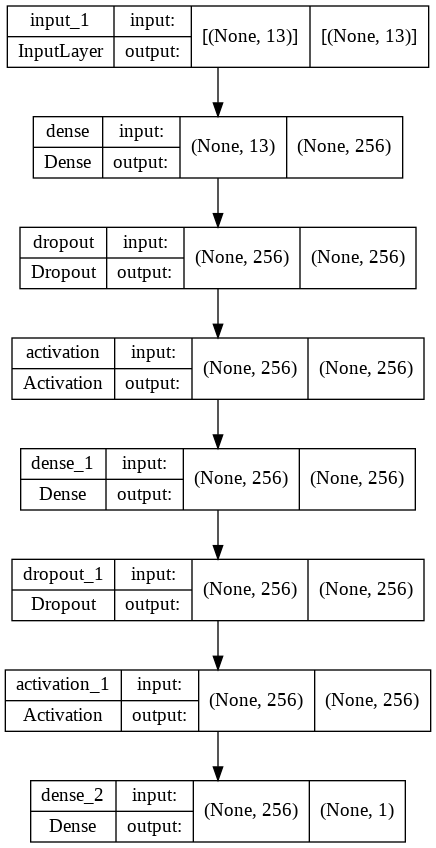

In [ ]:
tf.keras.backend.clear_session()

def create_model(dense_units = 256, dr = .2 ):

    input_ = Input(shape=(x_train.shape[1]))
    x = dense_block(input_, dense_units, dr)
    out = Dense(1)(x)
    model = Model(inputs = input_, outputs = out)
    return model
adam = tf.keras.optimizers.Adam()
model = create_model()
nadam = tf.keras.optimizers.Nadam(learning_rate=.001)
rmsprop = tf.keras.optimizers.RMSprop(learning_rate = .001, momentum=.9)
model.compile(loss = create_smape(), optimizer = 'adam', metrics = ['mae', 'mse',create_smape()])
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
early_stopping = EarlyStopping(patience = 7, restore_best_weights= True)
epochs = 100
lr_tuning = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-5 * 10**((4*epoch)/epochs))



history = model.fit(x_train, y_train, epochs = epochs, validation_data = [x_valid, y_valid], callbacks = [early_stopping], batch_size = 32)

Epoch 1/100
686/686 [==============================] - 3s 3ms/step - loss: 61.2551 - mae: 0.3015 - mse: 0.5364 - smape: 51.8415 - val_loss: 44.4188 - val_mae: 0.2974 - val_mse: 0.7384 - val_smape: 35.5657
Epoch 2/100
686/686 [==============================] - 2s 3ms/step - loss: 43.1152 - mae: 0.2285 - mse: 0.3787 - smape: 34.7300 - val_loss: 42.5794 - val_mae: 0.2925 - val_mse: 0.7149 - val_smape: 34.6548
Epoch 3/100
686/686 [==============================] - 2s 3ms/step - loss: 40.7605 - mae: 0.2222 - mse: 0.3645 - smape: 33.2895 - val_loss: 40.5740 - val_mae: 0.2924 - val_mse: 0.7209 - val_smape: 33.5586
Epoch 4/100
686/686 [==============================] - 2s 3ms/step - loss: 39.1117 - mae: 0.2187 - mse: 0.3507 - smape: 32.5514 - val_loss: 39.9424 - val_mae: 0.2949 - val_mse: 0.7353 - val_smape: 33.8327
Epoch 5/100
686/686 [==============================] - 2s 3ms/step - loss: 37.9241 - mae: 0.2170 - mse: 0.3507 - smape: 32.2505 - val_loss: 38.5381 - val_mae: 0.2933 - val_mse: 0.7

In [ ]:
# lrs = 1e-5 * (10 ** (4*np.arange(epochs) / epochs))

# plt.figure(figsize=(10, 6))
# plt.grid(True)
# plt.semilogx(lrs, history.history["loss"])
# plt.tick_params('both', length=10, width=1, which='both')
# plt.axis([1e-5, 1e-5 * 10**(4), 0, epochs])
# plt.show()

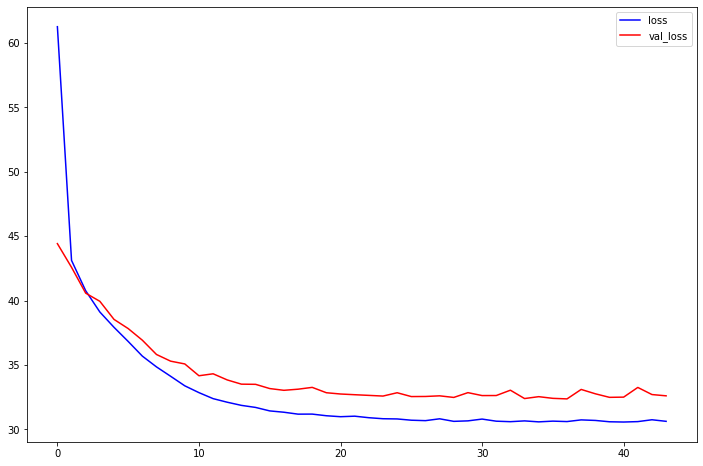

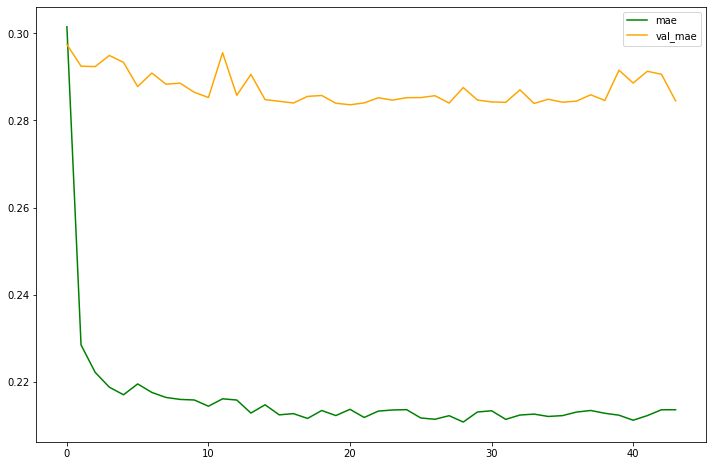

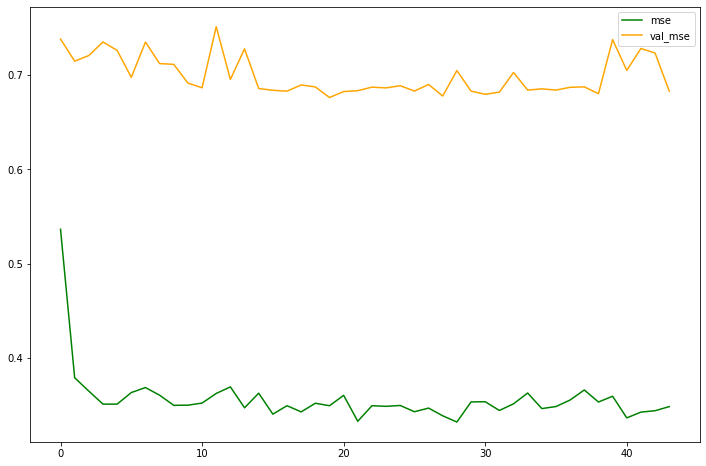

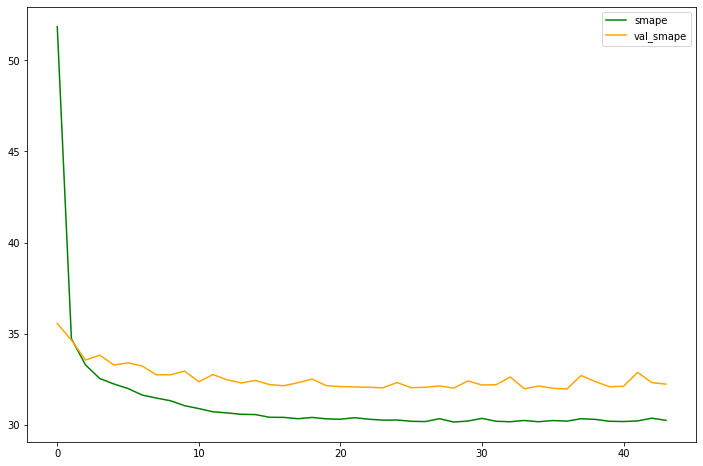

317/317 [==============================] - 0s 1ms/step - loss: 32.3686 - mae: 0.2844 - mse: 0.6872 - smape: 31.9721


[32.36859893798828, 0.2844388484954834, 0.6871535778045654, 31.972084045410156]

In [ ]:
plot_model_perf(history, ['mae','mse','smape'])
y_pred = model.predict(x_valid)
model.evaluate(x_valid, y_valid)

In [ ]:
def plot_predictions(data, dict_number, model = model):
  plt.figure(figsize = (20, 8))
  test_batch = data[dict_number].iloc[:,:-1]
  targets = data[dict_number].iloc[:,-1].values
  test_pred = model.predict(test_batch)
  vline = np.linspace(0, test_pred.shape[0], test_pred.shape[0])
  plt.plot(vline, test_pred.reshape(-1), color = 'red', label = 'Prediction')
  plt.plot(vline, targets.reshape(-1), color = 'green', label = 'Actual')
  plt.title(f'Prediction vs. actual for validation series {dict_number}')
  plt.xlabel("Week")
  plt.ylabel("Value")
  plt.legend()
  plt.show()

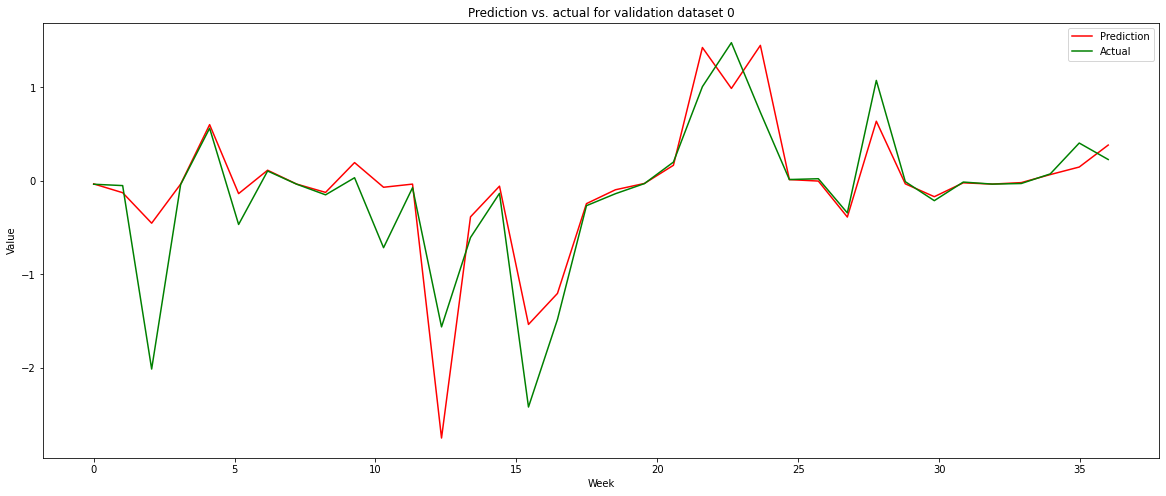

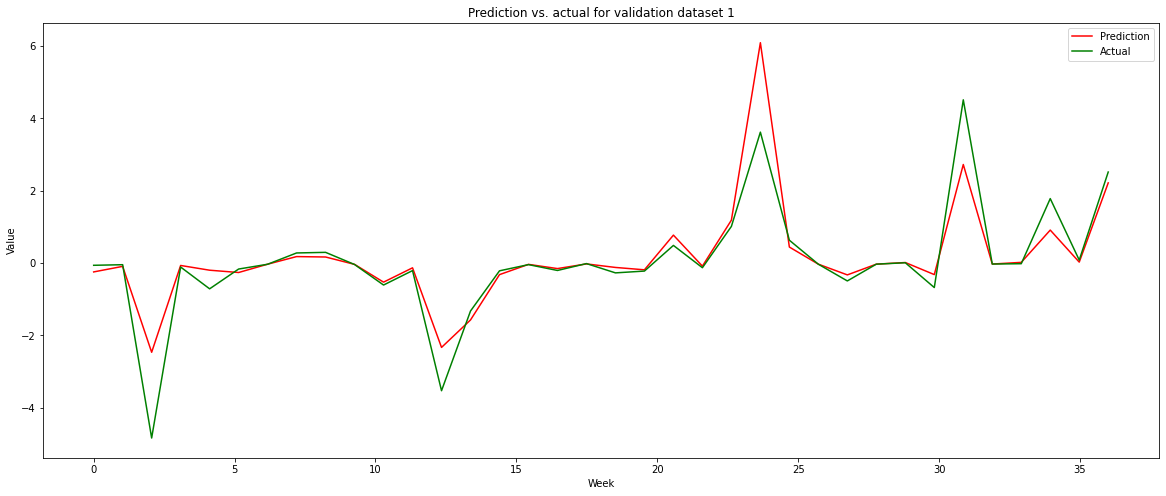

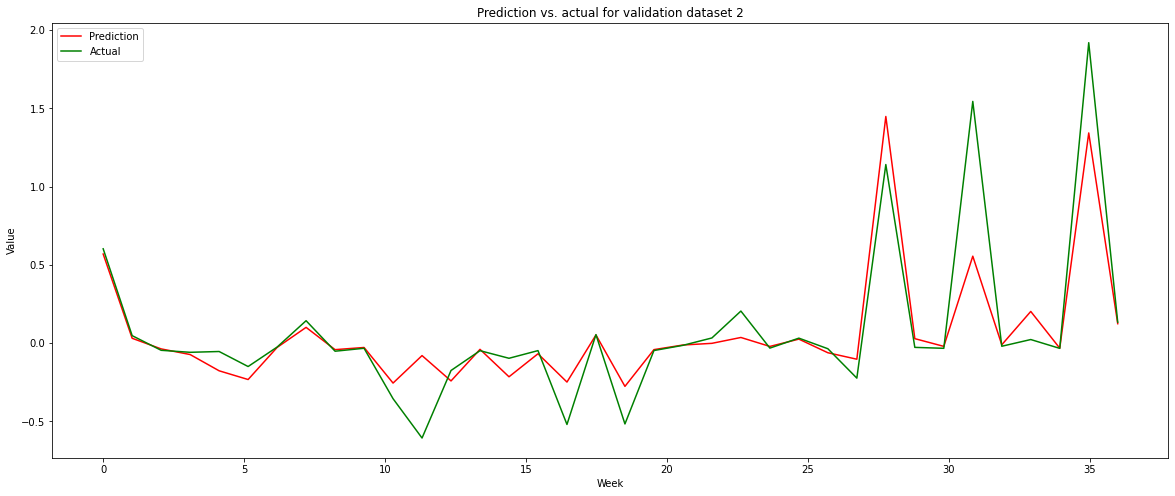

In [ ]:
for i in range(0, 3):
  plot_predictions(valid_scaled, i)

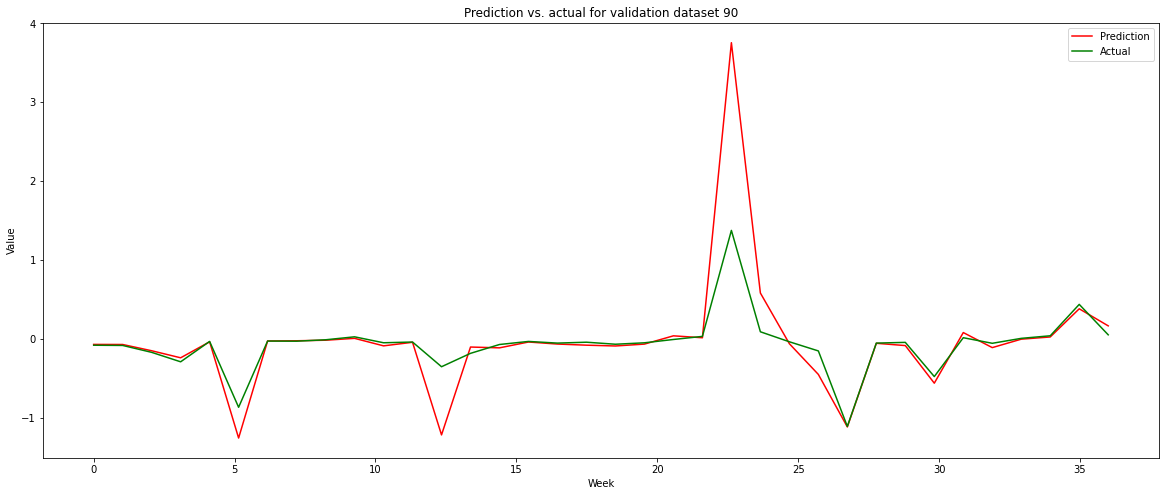

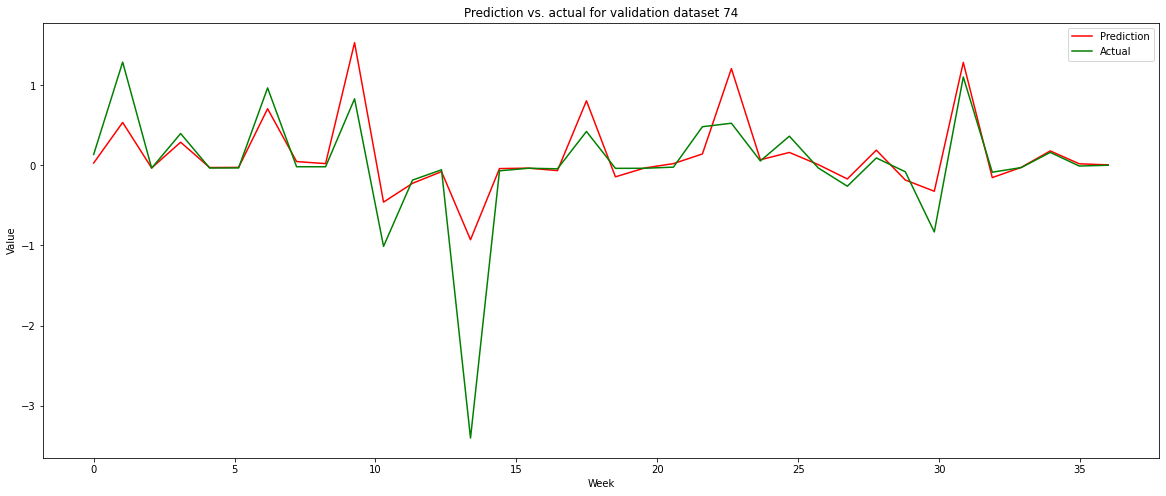

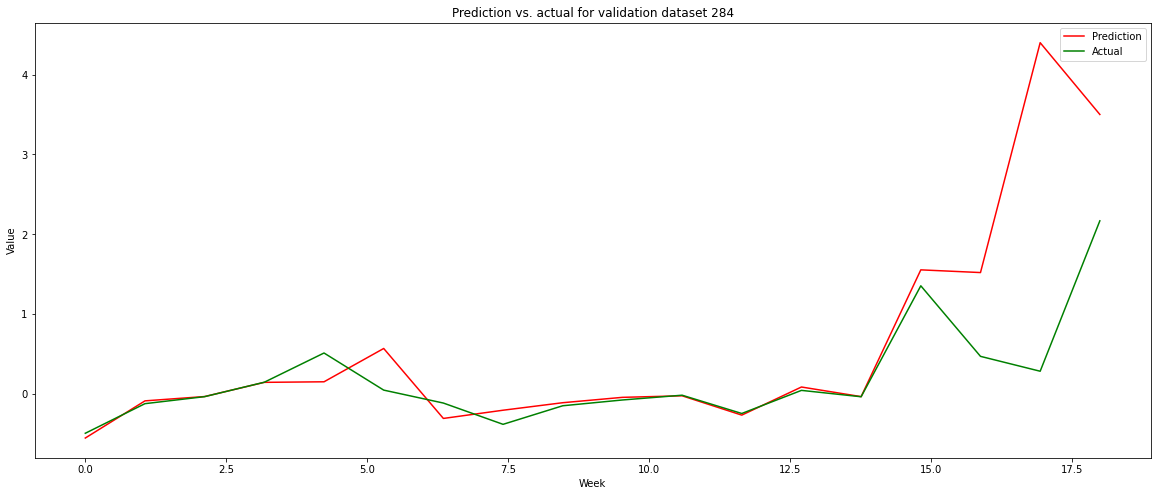

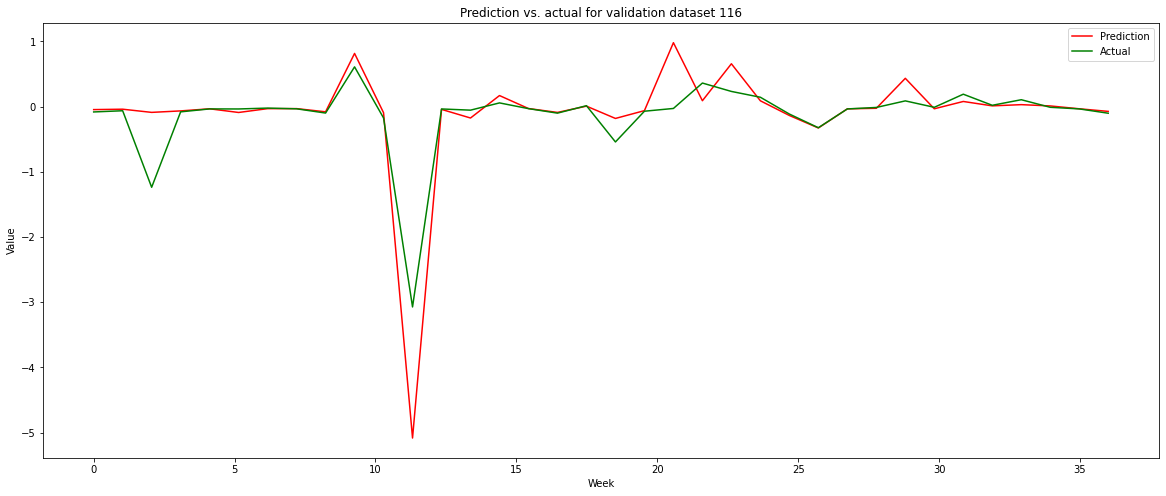

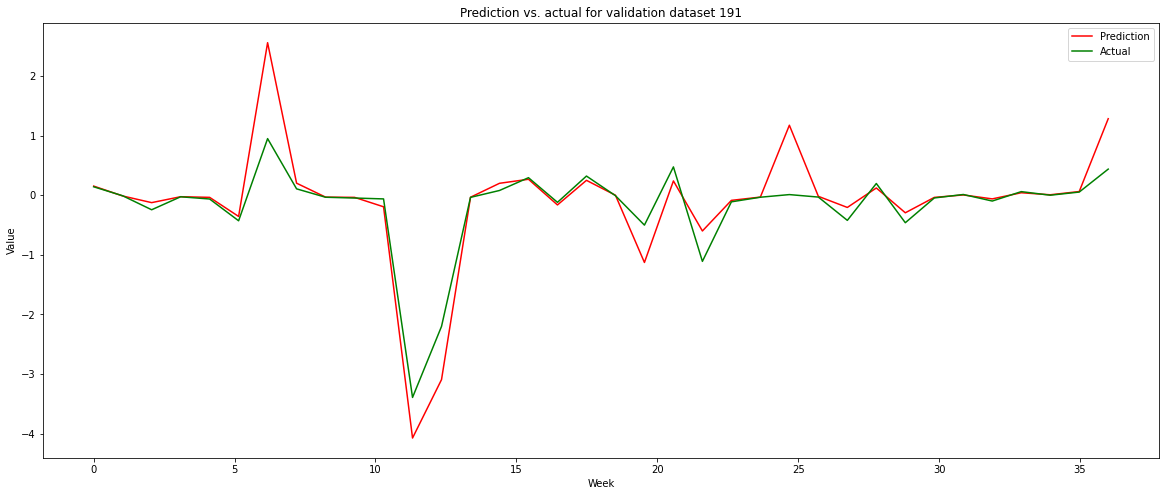

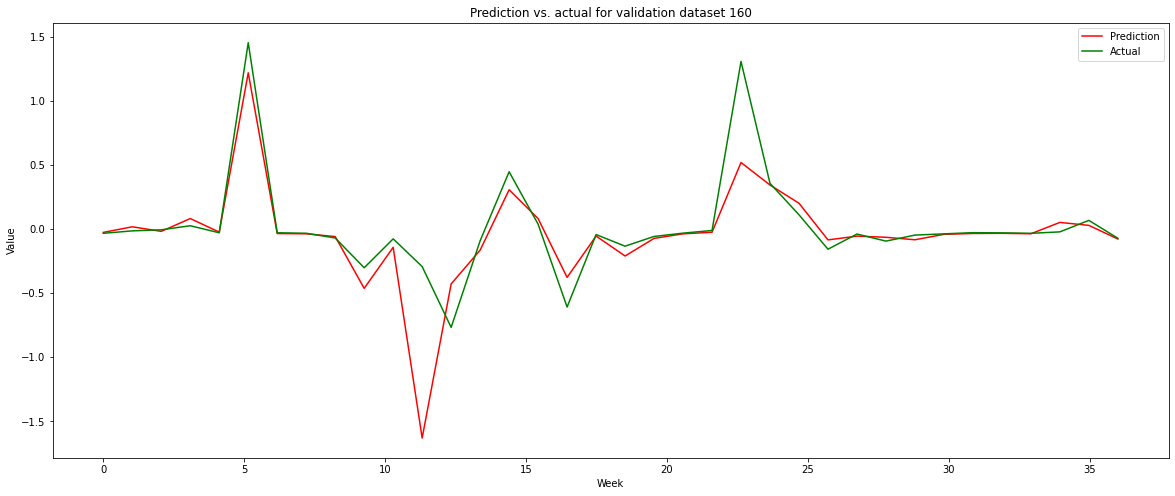

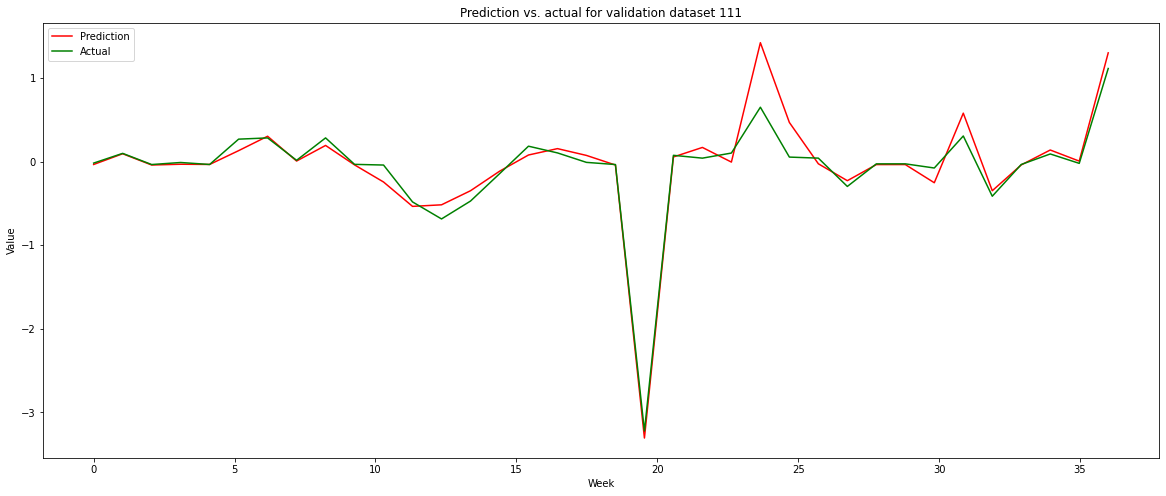

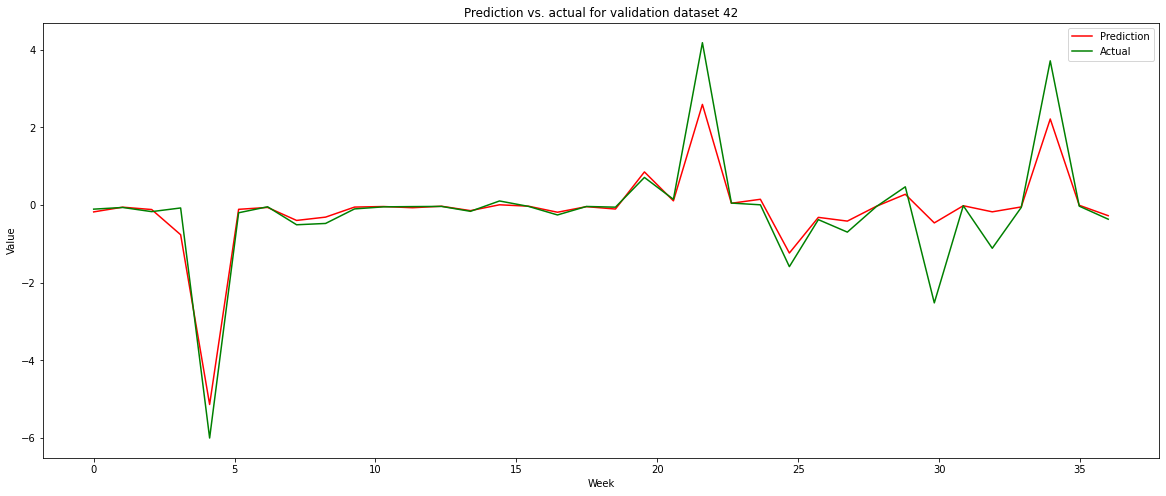

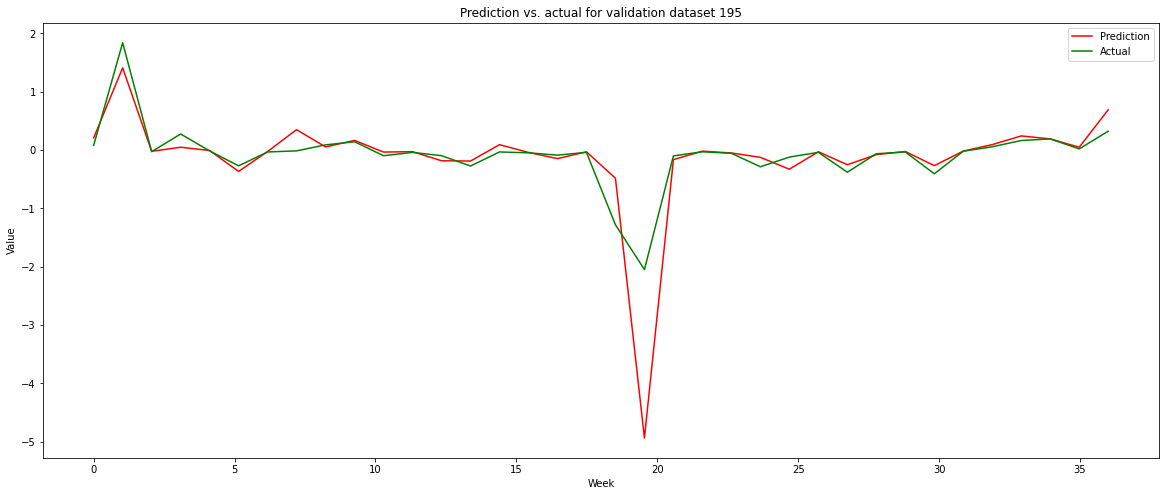

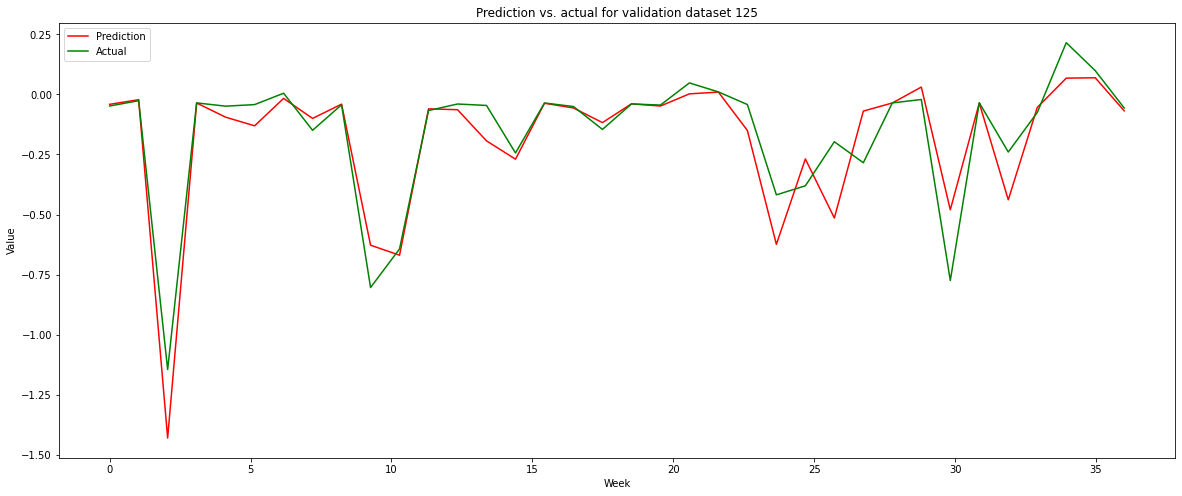

In [ ]:
for i in range(0,10):
  plot_predictions(valid_scaled, np.random.randint(0, len(valid_scaled)))

(13, 256)


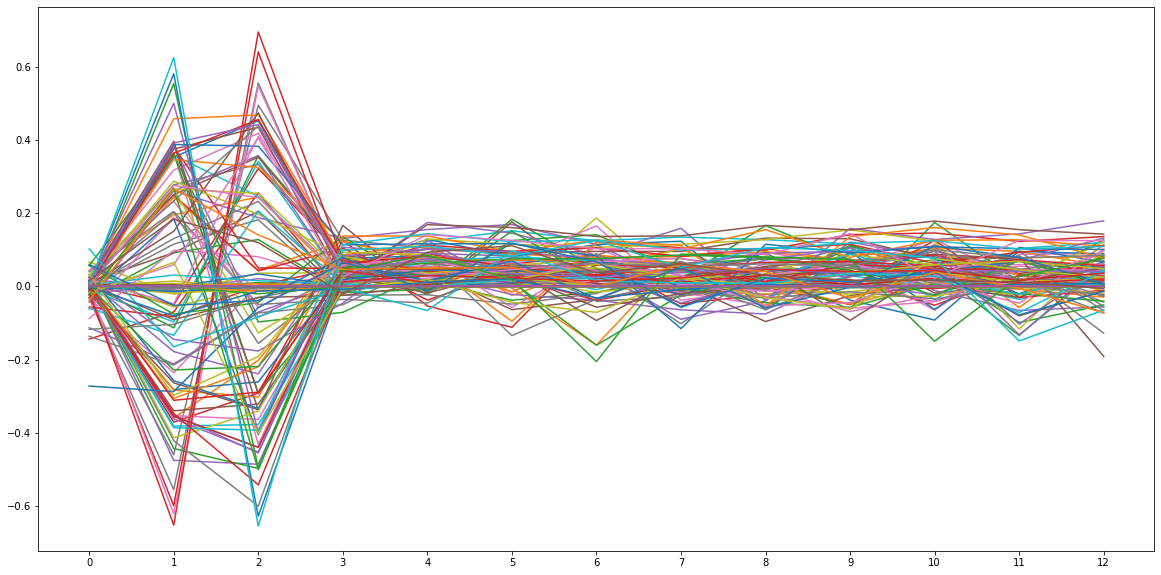

In [ ]:
x = np.squeeze(model.layers[1].get_weights()[0])
print(x.shape)
plt.figure(figsize = (20,10))
plt.xticks(range(0,x.shape[0]))
#plt.yscale('log')
plt.plot(x)